In [ ]:
# numpy random python uses Mersenne Twist pseudorandom genarator 
import numpy as np
from scipy.integrate import quad as integrate
import matplotlib.pyplot as plt

## Monte carlo Integration

In [ ]:
def f(x, alpha):
    """
    f(x) = x^alpha
    """
    return x**alpha

In [ ]:
def monte_carlo_integration(alpha, a, b, n_list):
    """
    Perform monte carlo algorithm to find
    integration of x^alpha from a to b.

    Parameters
    ----------
    alpha : float
        Power of x
    a : float
        Lower bound of integration
    b : float
        Upper bound of integration
    n_list : list
        List of number of samples
    
    Returns
    -------
    g_hat : float
        Simulated integration value
    
    g : float
        Numerically solved integral
    
    relative_error_list : list
        Relative error list between 
        g_hat and g

    """
    np.random.seed(1)
    relative_error_list = []
    for n in n_list:
        x = np.random.uniform(low=a,high=b,size=(n))
        M_n = f(x, alpha).sum()/n
        g_hat = (b-a)*M_n
        g = integrate(f,a,b,args=alpha)[0]
        relative_error = abs(g_hat - g)/g
        relative_error_list.append(relative_error)


    return g_hat,g,relative_error_list
    

In [ ]:
monte_carlo_integration(1,0,1,[10**5])

(0.49921911340158587, 0.5, [0.0015617731968282644])

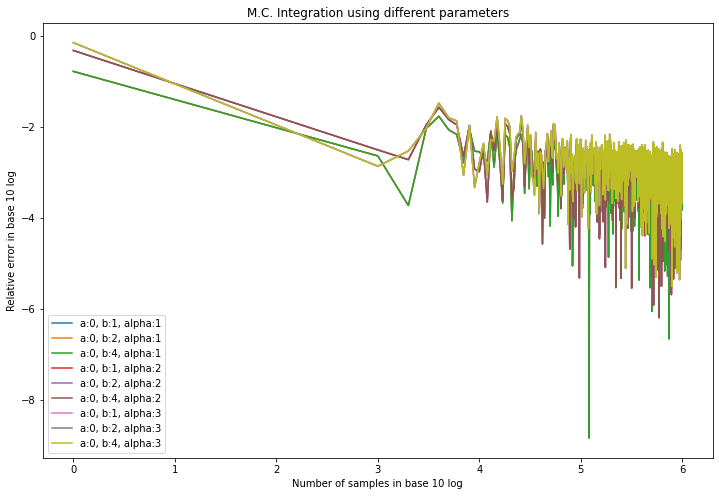

CPU times: user 2min 33s, sys: 990 ms, total: 2min 34s
Wall time: 2min 34s


In [ ]:
%%time
n_list = np.linspace(1, 10**6, num=1000, dtype=np.int32)
a = 0
b_list = [1,2,4]
alpha_list = [1,2,3]

plt.figure(figsize=(12,8))
plt.title('M.C. Integration using different parameters')
plt.ylabel('Relative error in base 10 log')
plt.xlabel('Number of samples in base 10 log')
for alpha in alpha_list:
    for b in b_list:
        _,_,error_list = monte_carlo_integration(alpha,a,b, n_list)
        # log-log plot using base 10
        plt.plot(np.log10(n_list),                
                np.log10(error_list),
                label=f'a:{str(a)}, b:{str(b)}, alpha:{str(alpha)}')
plt.legend()
plt.show()

